<center>
<img src="logo.png" height="900"> 
</center>


#  Авокадо

Хорошо известно, что миллениалы любят тосты с авокадо. Хорошо известно, что миллениалы живут со своими родителями. На самом деле они не могут купить себе дом, потому что едят слишком много тостов с авокадо. Но надежда есть. Если нам удастся найти город с дешёвым авокадо, миллениалы смогут туда переехать и накопить денег на собственные квартиры. В этом задании мы этим и займёмся!

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

In [1]:
# Поставим недостающий пакет
!pip3 install sktime --ignore-installed

  Using cached sktime-0.13.0-py3-none-any.whl (6.8 MB)
  Using cached pandas-1.4.3-cp38-cp38-win_amd64.whl (10.6 MB)
  Using cached numba-0.56.0-cp38-cp38-win_amd64.whl (2.5 MB)
  Using cached scikit_learn-1.1.1-cp38-cp38-win_amd64.whl (7.3 MB)
  Using cached Deprecated-1.2.13-py2.py3-none-any.whl (9.6 kB)
  Using cached scipy-1.8.1-cp38-cp38-win_amd64.whl (36.9 MB)
  Using cached statsmodels-0.13.2-cp38-cp38-win_amd64.whl (9.1 MB)
  Using cached numpy-1.22.4-cp38-cp38-win_amd64.whl (14.8 MB)
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached importlib_metadata-4.12.0-py3-none-any.whl (21 kB)
  Using cached setuptools-63.4.1-py3-none-any.whl (1.2 MB)
  Using cached llvmlite-0.39.0-cp38-cp38-win_amd64.whl (23.2 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached wrapt-1.14.1-cp38-cp38-win_amd64.whl (35 kB)
  Using ca

ERROR: pandas-profiling 3.1.0 has requirement joblib~=1.0.1, but you'll have joblib 1.1.0 which is incompatible.
ERROR: pandas-profiling 3.1.0 has requirement markupsafe~=2.0.1, but you'll have markupsafe 1.1.1 which is incompatible.


In [2]:
import numpy as np
import pandas as pd

from scipy import stats 
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
import statsmodels.api as sm
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster


import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import seaborn as sns
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import warnings 
warnings.filterwarnings('ignore')

## Данные

Данные взяты [с соревнавания на kaggle.](https://www.kaggle.com/neuromusic/avocado-prices) В табличке ниже представлены месячные данные по розничной торговле авокадо:

* `Date` - дата наблюдения
* `AveragePrice` - средняя цена одного авокадо
* `Type` - обычный или органический
* `Year` - год
* `Region` - город или регион наблюдения

Кроме этих колонок есть ещё несколько технических, но они нас не будут интересовать. 

In [4]:
dff = pd.read_csv('avocado_small.tsv', sep='\t', parse_dates=['Date']).set_index('Date')

# Периодичность данных - месячная 
dff.index = dff.index.to_period("M")

# будем смотреть только на тип organic 
dff = dff[dff.Type == 'organic'] 
print(dff.shape)
dff.head()

(2105, 4)


,AveragePrice,Region,Year,Type
Date,,,,
2015-12,1.84,Albany,2015,organic
2015-11,1.88,Albany,2015,organic
2015-10,1.98,Albany,2015,organic
2015-09,1.86,Albany,2015,organic
2015-08,2.00,Albany,2015,organic


Сразу же ответим на вопрос из шапки этой тетрадки и посмотрим как в разных городах цена на авокадо менялась год от года.

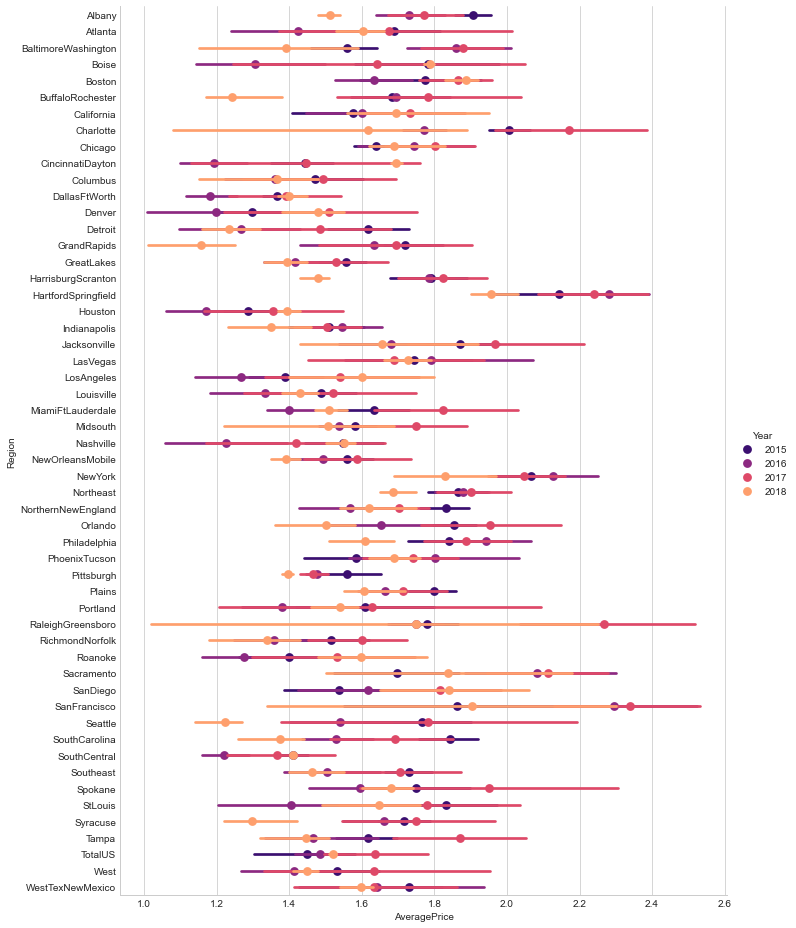

In [5]:
sns.factorplot('AveragePrice', 'Region', data=dff, hue='Year',
                size=13, aspect=0.8, palette='magma', join=False);

Кажется, что Сан-Франциско точно не подходит. Судя по всему, миллениалов может спасти Хьюстон. 

In [6]:
df = dff[['AveragePrice', 'Region']]
df.head()

,AveragePrice,Region
Date,,
2015-12,1.84,Albany
2015-11,1.88,Albany
2015-10,1.98,Albany
2015-09,1.86,Albany
2015-08,2.00,Albany


In [7]:
df.index.unique().size # 39 уникальных точек (месячные данные)

39

In [8]:
df.Region.unique().size # 54 города

54

Будем работать с Бостоном. Разобьём выборку на трейн и тест. С помощью функции `plot_series` 

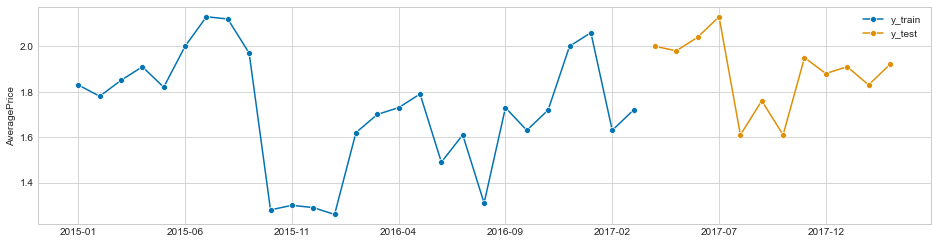

In [9]:
TEST_SIZE = 12
REGION = 'Boston'

y = df[df['Region'] == REGION].sort_index()['AveragePrice'].asfreq('m')
y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)
plot_series(y_train, y_test, labels=['y_train', 'y_test']);

In [10]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
             '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03'],
            dtype='period[M]', is_relative=False)

В качестве метрики качества будем использовать MAPE.

In [11]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Прогнозы и ансамбль

__[а]__ Постройте наивный прогноз. Выберите из трёх стратегий для строительства наивного прогноза самую лучшую. Качество модели, полученной на тестовом периоде запишите в переменную `ans1`. 

__Примечание:__ Cреднее для наивного прогноза считайте по окну размера`TEST_SIZE`.

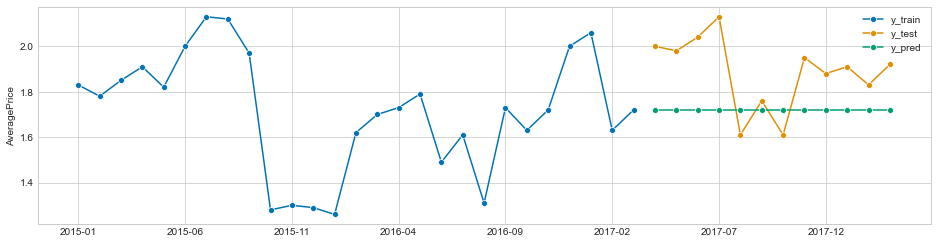

In [12]:
forecaster  = NaiveForecaster(strategy='last')
forecaster.fit(y_train)
y_pred = forecaster .predict(fh)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred']);

In [13]:
ans1 = mape(y_test, y_pred)
ans1

10.39037393153609

In [14]:
assert ans1  < 12

# несколько похожих скрытых тестов

__[б]__  Используя `sm.tsa.statespace.ExponentialSmoothing` обучите $ETS(AAA)$ модель. Поставьте `seasonal=12`. Постройте доверительный интервал для прогнозов. Изобразите его на картинке. Найдите качество работы модели на тестовой выборке и запишите результат в переменную `ans2`. Удалось ли улучшить наивный прогноз? 

In [15]:
ets_aaa = sm.tsa.statespace.ExponentialSmoothing(y_train, trend=True, seasonal=12)
ets_aaa_res = ets_aaa.fit()
print(ets_aaa_res.summary())

                        Exponential Smoothing Results                         
Dep. Variable:           AveragePrice   No. Observations:                   27
Model:                   ETS(A, A, A)   Log Likelihood                   1.714
Date:                Thu, 04 Aug 2022   AIC                             30.572
Time:                        12:41:08   BIC                             52.601
Sample:                    01-31-2015   HQIC                            37.122
                         - 03-31-2017   Scale                            0.052
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
smoothing_level          0.0001      0.181      0.001      0.999      -0.354       0.354
smoothing_trend          0.0001      0.064      0.002      0.999      -0.126       0.126
smoothing_se

In [16]:
df_forecast = ets_aaa_res.get_forecast(TEST_SIZE).summary_frame()
df_forecast.index = fh
df_forecast.head()

AveragePrice,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-04,1.760168,0.227087,1.315085,2.205251
2017-05,1.737646,0.227087,1.292562,2.182729
2017-06,1.680097,0.227087,1.235014,2.125180
2017-07,1.802085,0.227087,1.357001,2.247168
2017-08,1.650501,0.227087,1.205418,2.095584


In [17]:
ans2 = mape(y_test, df_forecast['mean'])
ans2

13.151970131888183

In [18]:
assert ans2 < 15

# несколько похожих скрытых тестов

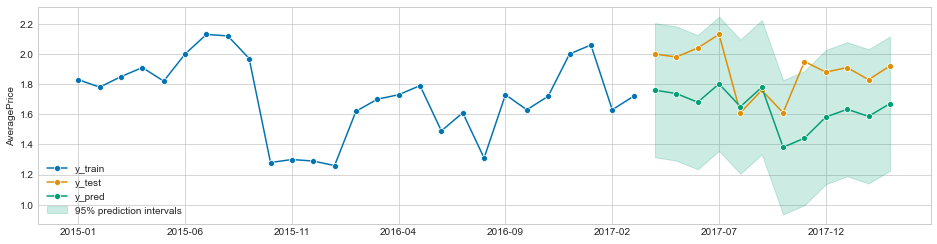

In [19]:
fig, ax = plot_series(y_train, y_test, df_forecast['mean'], labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["mean_ci_lower"],
    df_forecast["mean_ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');

Проведите диагностику модели. Правда ли, что остатки модели оказались нормальными? Можно ли использовать её для точечных прогнозов? Можно ли с её помощью строить для прогнозов надёжные доверительные интервалы? 

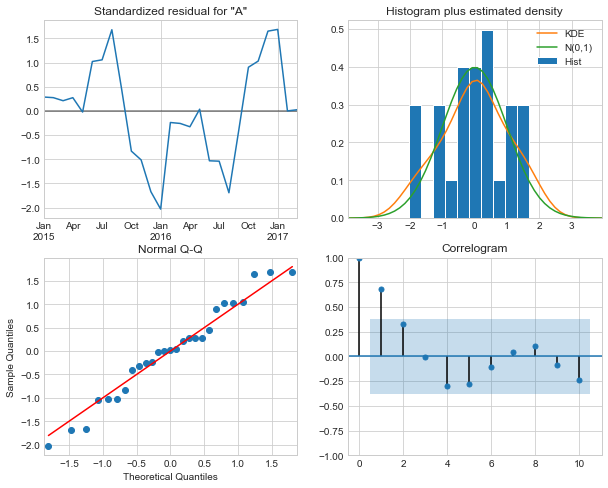

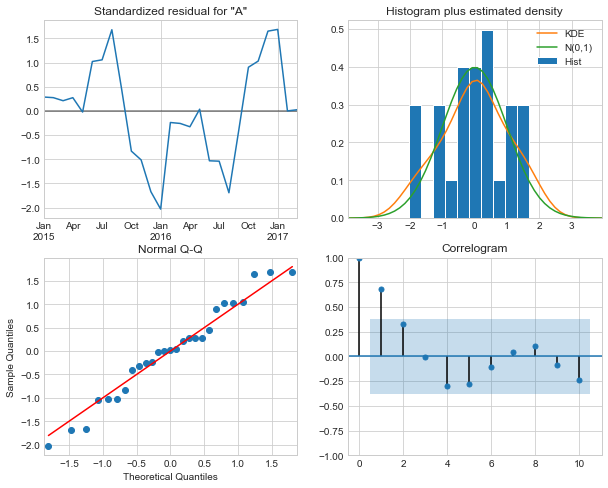

In [20]:
ets_aaa_res.plot_diagnostics(figsize=(10, 8))

__[в]__  Попробуем новую для нас модель, $TBATS$. Это некоторое улучшение $ETS$, с тем как оно работает, мы будем разбиратться на следующей неделе. Пока просто обучим её и посмотрим на метрику качества. Запишите MAPE модели на тестовой выборке `ans3`. Не забудьте нарисовать картинку с динамикой прогнозов. 

In [21]:
!pip install tbats

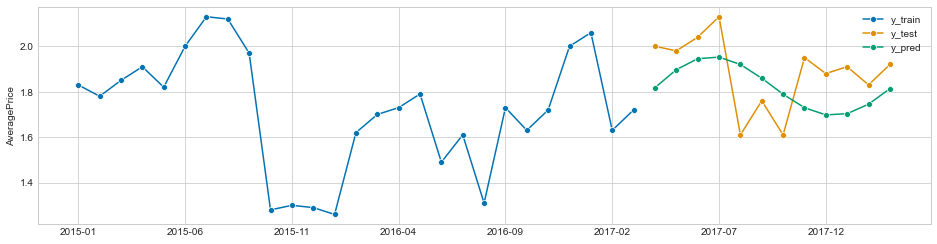

In [22]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12, 
                   use_trend=True, 
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred']);

In [23]:
ans3 = mape(y_test, y_pred)
ans3 

8.689743455096504

In [24]:
assert ans3 < 10

# несколько похожих скрытых тестов

__[г]__ Попробуем заключительную модель перед ансамблем, тетта-метод. В переменную `ans4` запишите получившеесся MAPE.

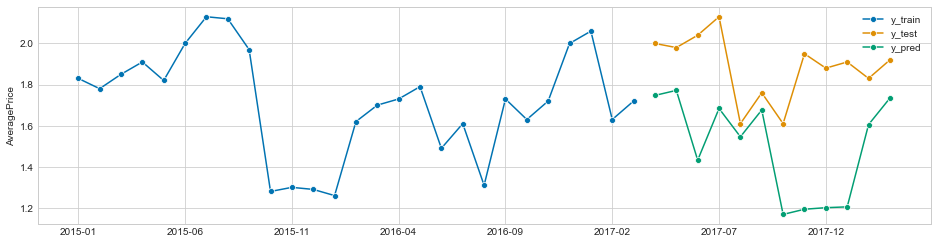

In [25]:
forecaster = ThetaForecaster(sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred']);

In [26]:
ans4 = mape(y_test, y_pred)
ans4

20.31600269689937

In [27]:
assert ans4 > 18

# несколько похожих скрытых тестов

__[д]__ Объединим все оценённые нами модели в ансамбль. Заполните недостающие части кода. В качестве `ans5` запишите MAPE для ансамбля. Удалось ли с помощью него получить хорошее качество? 

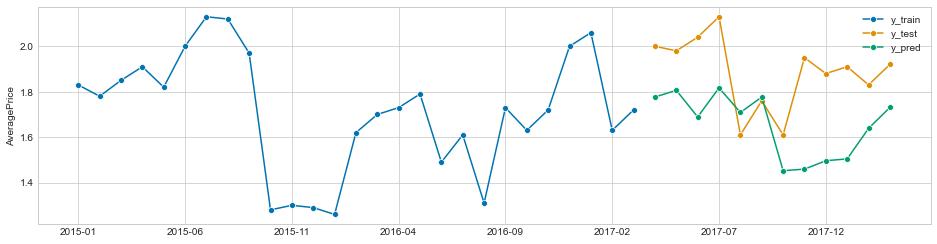

In [28]:
forecaster = EnsembleForecaster(
    [("ets",   ExponentialSmoothing(trend="add", seasonal="add", sp=12)),
     ("tbats", TBATS(sp=12, 
                   use_trend=True, 
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)),
     ("theta", ThetaForecaster(sp=12)) ])

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [29]:
ans5 = mape(y_test, y_pred)
ans5

12.986312590080498

In [30]:
assert ans5 > 10

# несколько похожих скрытых тестов

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# 2. Кросс-валидация

Понятное дело, что просто разбить выборку на трэйн и тест, а затем построить прогноз на всю тестовую часть - мало. Такие оценки качества моделей не очень стабильны. Более того, при прогнозировании на разные горизонты, мы получаем разные ошибки.

Для кросс-валидации будем использовать класс [SlidingWindowSplitter,](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html#sktime.forecasting.model_selection.SlidingWindowSplitter) в рамках которого реализовано скользящее окно. В тестовой выборке будем держать три месяца.

На семинаре мы использовали средства sklearn, но sktime на порядок удобнее. 

In [31]:
# параметры для кросс-валидации
window_length = 27                     # y_train.size
fh = ForecastingHorizon([1, 2, 3])     # максимум на 3 месяца вперёд
fh_length = len(fh)                    # даты для тестовой выборки

cv_window = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv_window.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 10


Выглядеть наше разбиение будет вот таким образом. Голубое - обучающая выборка, оранжевое - тестовая. Найти код для строительства такой картинки можно [в документации.](https://github.com/alan-turing-institute/sktime/blob/master/examples/window_splitters.ipynb) Там же описано много других стратегий кросс-валидации, уже реализованных в рамках пакета. 

![](split.png)

Попробуем провести кросс-валидацию для Тетта-метода. Допишите в функции ниже нехватающие для этого части.

In [32]:
def mape(y_true, y_pred): 
    return np.abs((y_true - y_pred) / y_true)* 100

def cross_val_sccore(forecaster, y, cv=cv_window):
    M = [ ]

    for idx_train, idx_val in cv.split(y):
        
        y_tr = y[idx_train]
        y_val = y[idx_val]
        fh_val = ForecastingHorizon(y_val.index, is_relative=False)
        
        # обучение модели
        forecaster.fit(y_tr)
        y_pred = forecaster.predict(fh_val)
        
        M.append(mape(y_val, y_pred).values)
        
    return np.array(M)

M = cross_val_sccore(ThetaForecaster(sp=12), y)
quality = M.mean(axis=0)
quality

array([11.08963128, 14.67886754, 14.9084376 ])

В векторе quality записано три различных значения MAPE нашей модели при прогнозировании на месяц, два и три вперёд.

In [33]:
assert M.shape == (10, 3) # это не тест на оценку, его можно закоментить при отправке в грейдер

Проведите кросс-валидацию для всех моделей из списка ниже. Какая из них показывает наилучший результат? В переменную `ans6` запишите номер модели, которая лучше всего прогноизрует на месяц вперёд. В перемменную `ans7` запишите номер модели, которая лучше всего прогнозирует на три месяца вперёд. Провизуализируйте получившееся качество на картинке по аналогии с семинаром.

In [34]:
forecaster_1 = NaiveForecaster(strategy="last")
forecaster_2 = NaiveForecaster(strategy="mean", window_length=12)
forecaster_3 = NaiveForecaster(strategy="last", sp=12)

forecaster_4 = ThetaForecaster(sp=12)
forecaster_5 = AutoETS(auto=True, sp=12, n_jobs=-1, information_criterion='bic')

forecaster_6 = TBATS(sp=12, 
                    use_trend=True, 
                    use_damped_trend=True,
                   use_arma_errors=True,
                    use_box_cox=True)

for X in [forecaster_1, forecaster_2, forecaster_3, forecaster_4, forecaster_5, forecaster_6]:
    M= cross_val_sccore(X, y)
    print(str(X), M.mean(axis=0)[0], M.mean(axis=0)[2])

NaiveForecaster() 9.504424601787951 14.114454773399924
NaiveForecaster(strategy='mean', window_length=12) 10.056733962788744 7.315006007076358
NaiveForecaster(sp=12) 12.208146496128949 12.03311337806304
ThetaForecaster(sp=12) 11.089631281776494 14.9084376010374
AutoETS(auto=True, information_criterion='bic', n_jobs=-1, sp=12) 8.78054390488009 12.965998063482775
TBATS(sp=12, use_box_cox=True, use_damped_trend=True, use_trend=True) 10.352422171163703 8.886307531000336


In [35]:
ans6, ans7 = 5, 2

In [36]:
assert ans6 > 0
assert ans7 > 0
assert ans6 < 7 
assert ans7 < 7

# несколько похожих скрытых тестов

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# Необязательное задание:

1. Попробуйте прогнать наш пайплайн на всех городах. Найдите модель, которая побеждает в качестве прогноза чаще всего.

2. Прочитайте [туториал от sktime,](https://nbviewer.jupyter.org/github/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb) в нём вы найдёте пример того как делать Griidsearch, а также онлайн-прогнозирование с постепенно сдвигающимся окном. Попробуйте добавить в наш пайплайн [другие модели](https://www.sktime.org/en/latest/api_reference.html#sktime-forecasting-time-series-forecasting) и сравнить их между собой. Можно попробовать добавить `Autoarima`, `Prophet`, `KNeighborsRegressor`. Обязательно посстарайтесь разобраться, как именно они строят свой прогноз. Если не выходит, приходите на форум, будем разбираться вместе! 

2. На гите библиотеки [есть довольно много примеров кода.](https://github.com/alan-turing-institute/sktime/tree/master/examples)

 ## Разбираемся в теории:
 
В этом задании вы встретились с таким алгоритмом, как Тетта-метод. Его придумали в $2000$ году и он довольно простой. Попробуйте [самостоятельно разобраться с ним](https://robjhyndman.com/papers/Theta.pdf) по аналогии с тем, как мы на лекциии разбирали другие модели: 
 
 1. Выпишите уравнение модели
 2. Разбиритесь как строится точечный прогноз
 3. Разберитессь как строится доверительный интервал 
 4. Придумайте простую задачку с цифрами, из 5 наблюдений, и решите её на листочке

Не пугайтесь формул из статьи! Они и правда могут показаться страшными. 